In [1]:
#!/usr/bin/python
#last updated DBR 1/28/20
#do the power law fitting

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

#my power law fitter
import ra_module

#make it easier to edit the module and rerun automatically
%load_ext autoreload
%autoreload 2

printforAnnie=True #flag in to spit out data for Annie's figures

In [3]:
#      tART     t1       t2        t3
#1211: 05/2006, 05/2008, 09/2011
#22:   10/2006, 10/2008, 08/2016
#548:  05/2002, 10/2003, 01/2014
#583:  07/2003, 05/2005  07/2014
#746:  01/2004, 11/2005, 03/2014
#1124: 08/2010, 03/2011  09/2017
#1194: 04/2010, 10/2010  09/2017
#1532: 06/2010, 01/2011, 03/2014,  10/2017

#times in months since ART, in order with those above
tART=[[24,24,17,22,22,7,6,7],[64,118,140,132,122,85,89,45]]


In [16]:
#check on approximation for maximum richness
al=0.9
R=10**5
print((R**(1-al)-1)/(1-al),np.sum(np.arange(1,R)**-al))

21.622776601683793 22.192646770869516


In [17]:
#reservoir sizes (per mil cd4+)
L_df=pd.read_excel('reservoir_size_dbr.xlsx')

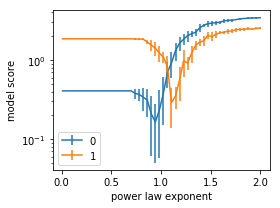

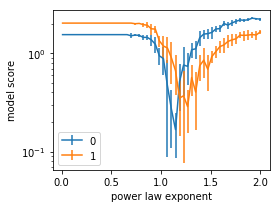

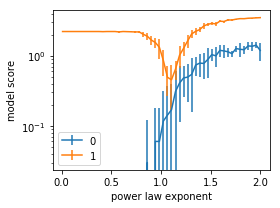

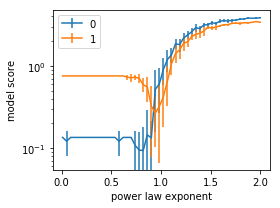

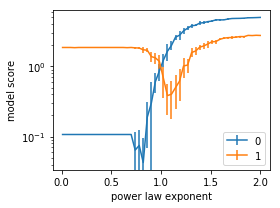

In [71]:
#fit power laws for HIV integration sites
#not for elite controllers
HIVal=[]
for j in range(5):
    tdf=df[ppts[j]]
    plt.figure(figsize=(4,3))
    for ti in range(2):
        
        L=L_df[L_df['pid']==int(ppts[j])]['totalcells'].iloc[ti]
        Rscl=1000*L
        
        c=tdf['Times seen in Timepoint '+str(ti+1)]

        a=-np.sort(-c)
        dat_abund=a[a>0]
        N=np.sum(dat_abund)
        
        Rn=len(dat_abund)/N
        
        fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=50,num_replicates=10,dat_abund=dat_abund,R=Rscl,max_al=2)

        best_al=fit_al[np.argmin(fit_score[0])]

        HIVal.append([ppts[j],tART[ti][j],best_al,Rn,L,ti,N])
        plt.errorbar(fit_al,fit_score[0],fit_score[1],label=ti)

    plt.semilogy()
    plt.legend()
    plt.xlabel('power law exponent')
    plt.ylabel('model score')
    plt.tight_layout()
    plt.savefig('figures/HIV_alphafits'+ppts[j]+'.pdf',dpi=600)

In [72]:
#make the df
td=pd.DataFrame(HIVal,columns=('ID','monthsART','alpha','Rn','res_size','tpt','N'))

#drop the N=10 ppt (or not)
#td=td.drop(index=[4])

if printforAnnie:
    pd.DataFrame.to_csv(td,'data/fit_alphas.csv')

td

,ID,monthsART,alpha,Rn,res_size,tpt,N
0,1211,24,0.944082,0.940000,4104.884538,0,50
1,1211,64,1.106531,0.737705,3978.524773,1,61
2,22,24,1.147143,0.744681,1952.684249,0,47
3,22,118,1.268980,0.619048,1144.808214,1,42
4,548,17,0.010000,1.000000,37742.806503,0,10
5,548,140,1.106531,0.734043,1583.169118,1,94
6,583,22,0.822245,0.981481,969.180169,0,54
7,583,132,0.944082,0.896552,592.696214,1,58
8,746,22,0.822245,0.988372,2717.704435,0,86
9,746,122,1.065918,0.750000,1495.120545,1,68


In [73]:
st.mannwhitneyu(td[td['tpt']==0]['alpha'],td[td['tpt']==1]['alpha'])

MannwhitneyuResult(statistic=4.5, pvalue=0.056923149003329024)

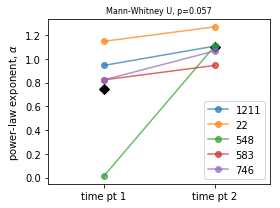

In [74]:
#comparing the distributions using power law fits

#these are calculated in the same script (above)
al1=list(td[td['tpt']==0]['alpha'])
al2=list(td[td['tpt']==1]['alpha'])
    
#plot results
plt.figure(figsize=(4,3))
for ppt in td['ID'].unique():
    tdf=td[td['ID']==ppt]
    plt.plot([1,2],[tdf['alpha'].iloc[0],tdf['alpha'].iloc[1]],'-o',alpha=0.7,label=ppt)

al1=td[td['tpt']==0]['alpha']
al2=td[td['tpt']==1]['alpha']

plt.scatter(1,np.mean(al1),s=50,marker='D',color='k')
plt.scatter(2,np.mean(al2),s=50,marker='D',color='k')
    
#plt.ylim([0.5,1.05])
plt.xlim([0.5,2.5])
plt.ylabel(r'power-law exponent, $\alpha$')
plt.xticks([1,2],['time pt 1','time pt 2'])
plt.legend()

#plt.title('ttest, p='+str(round(st.ttest_1samp(al1,al2)[1],3)),fontsize=8)
plt.title('Mann-Whitney U, p='+str(round(st.mannwhitneyu(al1,al2)[1],3)),fontsize=8)

plt.tight_layout()
plt.savefig('figures/pwls.pdf',dpi=600)

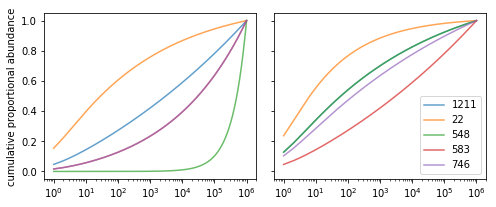

In [126]:
#plot cumulative proportional abundances
  
#plot results
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(7,3))
a_props=[[],[]]
for ppt in td['ID'].unique():
    tdf=td[td['ID']==ppt]
    
    for tt in range(2):
        R=10**6
        r=np.arange(1,R)

        a=r**(-tdf['alpha'].iloc[tt])
        
        axs[tt].semilogx(r,np.cumsum(a)/np.sum(a),ls='-',alpha=0.7,label=ppt)

        a_props[tt].append([np.sum(a[:10])/np.sum(a),
                    np.sum(a[:100])/np.sum(a),
                    np.sum(a[:1000])/np.sum(a)])

axs[0].set_ylabel('cumulative proportional abundance')
axs[1].legend()

plt.tight_layout()
plt.savefig('figures/cpas.pdf',dpi=600)

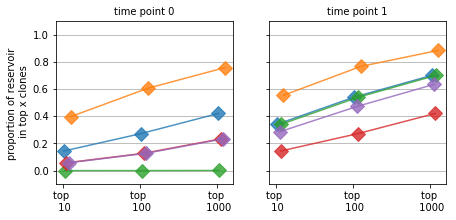

In [137]:
#plot the proportions
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(7,3))
for tt in range(2):
    for j in range(5):    
        axs[tt].plot(np.arange(1,4)+np.random.rand()/10,a_props[tt][j],ls='-',marker='D',markersize=10,alpha=0.8)
    
    axs[tt].set_xticks([1,2,3])
    axs[tt].set_xticklabels(['top \n 10','top \n 100','top \n 1000'])
    axs[tt].set_title('time point '+str(tt),fontsize=10)
    axs[tt].grid(axis='y')    
axs[0].set_ylabel('proportion of reservoir \n in top x clones')
axs[0].set_ylim([-0.1,1.1])
#plt.savefig('figures/cpas_top.pdf',dpi=600)

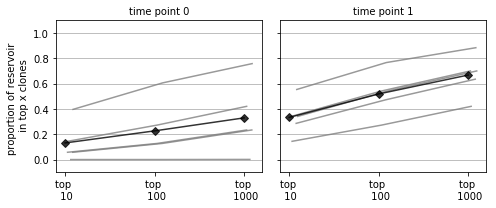

In [143]:
#plot the proportions (mean)
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(7,3))
for tt in range(2):
    for j in range(5):    
        axs[tt].plot(np.arange(1,4)+np.random.rand()/10,a_props[tt][j],ls='-',color='gray',alpha=0.8)
    
    axs[tt].plot(np.arange(1,4),np.mean(a_props[tt],0),ls='-',color='black',marker='D',alpha=0.8)
    axs[tt].set_xticks([1,2,3])
    axs[tt].set_xticklabels(['top \n 10','top \n 100','top \n 1000'])
    axs[tt].set_title('time point '+str(tt),fontsize=10)
    axs[tt].grid(axis='y')    
axs[0].set_ylabel('proportion of reservoir \n in top x clones')
axs[0].set_ylim([-0.1,1.1])
fig.tight_layout()
#fig.savefig('figures/cpas_top2.pdf',dpi=600)

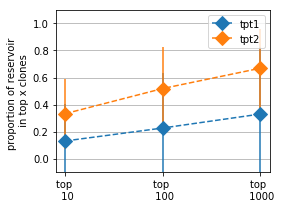

In [154]:
#plot the proportions (mean)
fig,axs=plt.subplots(1,1,figsize=(4,3))
czz=['tab:blue','tab:orange']
for tt in range(2):    
    #for j in range(5):    
    #    axs.plot(np.arange(1,4)+np.random.rand()/10,a_props[tt][j],ls='-',color=czz[tt],alpha=0.5)
    axs.errorbar(np.arange(1,4),np.mean(a_props[tt],0),1.96*np.std(a_props[tt],0),ls='--',marker='D',markersize=10,alpha=1,label='tpt'+str(tt+1))
    #axs.plot(np.arange(1,4),np.mean(a_props[tt],0),ls='--',marker='D',markersize=10,alpha=1,label='tpt'+str(tt+1))
axs.set_xticks([1,2,3])
axs.set_xticklabels(['top \n 10','top \n 100','top \n 1000'])
axs.grid(axis='y')    
axs.set_ylabel('proportion of reservoir \n in top x clones')
axs.set_ylim([-0.1,1.1])
axs.legend()
fig.tight_layout()
#fig.savefig('figures/cpas_top3.pdf',dpi=600)

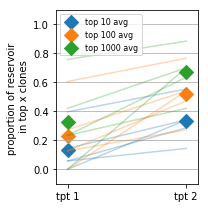

In [196]:
plt.figure(figsize=(3,3))
axs=plt.subplot(111)
czz=['tab:blue','tab:orange','tab:green']
for pct in range(3):
    for ppt in range(5):    
        axs.plot([1,2],np.array(a_props)[:,ppt,pct],ls='-',color=czz[pct],alpha=0.3)

    axs.scatter([1,2],np.mean(a_props,1)[:,pct],marker='D',s=100,alpha=1,c=czz[pct],label='top '+str(10**(pct+1))+' avg')
axs.legend(loc=2,fontsize=8)
axs.grid(axis='y')    
axs.set_ylabel('proportion of reservoir \n in top x clones')
axs.set_xlim([0.9,2.1])
axs.set_ylim([-0.1,1.1])
axs.set_xticks([1,2])
axs.set_xticklabels(['tpt 1','tpt 2'])
plt.tight_layout()
plt.savefig('figures/cpas_top4.pdf',dpi=600)


In [ ]:
#plot the proportions (mean)
fig,axs=plt.subplots(1,1,figsize=(4,3))
czz=['tab:blue','tab:orange']
for tt in range(2):    
    #for j in range(5):    
    #    axs.plot(np.arange(1,4)+np.random.rand()/10,a_props[tt][j],ls='-',color=czz[tt],alpha=0.5)
    axs.errorbar(np.arange(1,4),np.mean(a_props[tt],0),1.96*np.std(a_props[tt],0),ls='--',marker='D',markersize=10,alpha=1,label='tpt'+str(tt+1))
    #axs.plot(np.arange(1,4),np.mean(a_props[tt],0),ls='--',marker='D',markersize=10,alpha=1,label='tpt'+str(tt+1))
axs.set_xticks([1,2,3])
axs.set_xticklabels(['top \n 10','top \n 100','top \n 1000'])
axs.grid(axis='y')    
axs.set_ylabel('proportion of reservoir \n in top x clones')
axs.set_ylim([-0.1,1.1])
axs.legend()
fig.tight_layout()
fig.savefig('figures/cpas_top3.pdf',dpi=600)

In [ ]:
#compare the probability masses of the first 10,100,1000 clones

#how many are in the top 1%?
#how much does the top 1% own? 
  


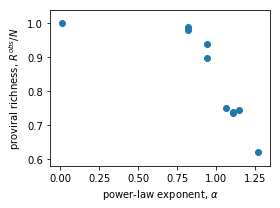

In [76]:
#compare normalized richness and power law
plt.figure(figsize=(4,3))
plt.scatter(td['alpha'],td['Rn'])

#plt.ylim([0.5,1.05])
#plt.xlim([0.5,2])
plt.xlabel(r'power-law exponent, $\alpha$')
plt.ylabel('proviral richness, ' + r'$R^{obs}/N$')
plt.tight_layout()
plt.savefig('figures/corr_al_Rn.pdf',dpi=600)

#some theory for this?
#alz=np.linspace(0,2,100)
#plt.plot(alz,2/(1+np.exp(alz/2)),'--k')
